<img src="./images/DLI_Header.png">

# Review of Neural Network Optimization

Welcome to the first lab of the course. The goal of this exercise is threefold:

- Review some basic concepts of neural network training and establish a common vocabulary for the class.
- Illustrate the basic principles involved in training of a neural network (in particular, stochastic gradient descent).
- Create a foundation for the next labs in this class that will eventually lead us to a multi-GPU implementation of a neural network.

We will start with the simplest possible neural network, a single linear neuron:

<img src="https://developer.download.nvidia.com/training/images/C-MG-01-V1_task1_img_LinearNeuron.png" width="300" height="300"/> 

We will illustrate how this neural network can be trained using gradient descent and stochastic gradient descent algorithms. 

Upon completion of this exercise you will gain a detailed understanding on the theory involved in training a neural network, focusing initially only on a single GPU. We will use this knowledge later to illustrate all of the practical challenges involved in large scale distributed training and review a state of the art implementation of a distributed training of a modern deep neural network.

## Training a neural network

### Generating a random dataset

In this exercise we will train our neural network to fit a randomly generated dataset representing a line with random noise added to it. We are choosing to use a simple neural network that matches this dataset: although the equation for a line cannot exactly match the data, due to the noise, it is a very good approximation that still allows us to dig into the neural network training process.

We start by importing the necessary Python libraries. Since this exercise is deliberately simple the list is quite short:

In [ ]:
# Numpy is a fundamental package for scientific computing. It contains an implementation of an array
# that we will use in this exercise.
import numpy as np
# We will be generating our own random dataset. As a consequence we need functionality to generate random numbers.
import random
# We will be plotting the progress of training using matplotlib, a package that can be used to generate 2D and 3D plots.
# We use the "widget" option to enable interactivity later on.
%matplotlib widget
import matplotlib.pyplot as plt
# We will use TensorFlow as the deep learning framework of choice for this class.
import tensorflow as tf

The variables listed below define the properties of this generated dataset. Let’s start with the given values (feel free to change them at a later stage to observe the impact the noise will have on algorithm performance and stability).

In [ ]:
# Define the number of samples/data points you want to generate
n_samples = 100
# We will define a dataset that lies on a line as defined by y = w_gen * x + b_gen
w_gen = 10
b_gen = 2
# To make the problem a bit more interesting we will add some Gaussian noise as 
# defined by the mean and standard deviation below.
mean_gen = 0
std_gen = 1

In [ ]:
# This section generates the training dataset as defined by the variables in the section above.
x = np.float32(np.random.uniform(0, 10, n_samples))
y = np.float32(np.array([w_gen * (x + np.random.normal(loc=mean_gen, scale=std_gen, size=None)) + b_gen for x in x]))

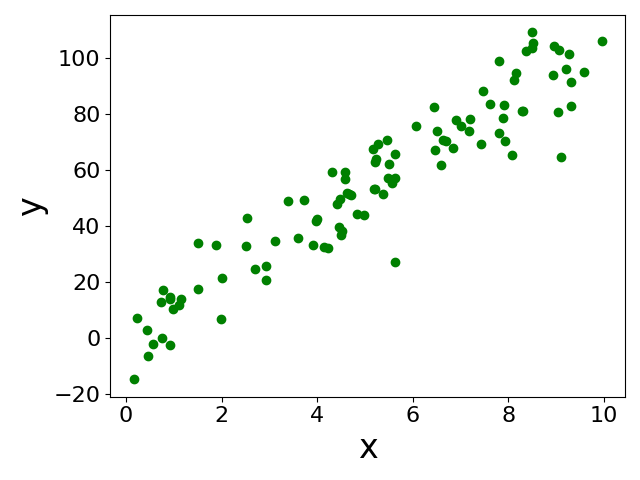

In [ ]:
# Plot our randomly generated dataset
plt.close()
plt.plot(x, y, 'go')
plt.xlabel("x", size=24)
plt.ylabel("y", size=24)
plt.tick_params(axis='both', labelsize=16)
plt.tight_layout()
plt.show()

### Defining the model

Regardless of the complexity of the machine learning problem the process of code development consists of:

- Creating a definition of the model
- Defining the loss (cost) function that will guide our training process. The loss function is effectively a definition of success that informs our optimization algorithm about the progress made during training. </li>
- Then iteratively:
  - Calculating the gradient of the loss function with respect to the model weights.
  - Updating the model weights (in the direction opposite to the gradient) to minimize the loss function.

Let's implement the above for our simple model. We start by defining the model:

In [ ]:
# Define the TensorFlow variables based on our inputs
X = tf.Variable(x, name="X")
Y = tf.Variable(y, name="Y")

# Create our model variables w (weights; this is intended to map to the slope, w_gen) and b (bias; this maps to the intercept, b_gen).
# For simplicity, we initialize the data to zero.
w = tf.Variable(np.float32(0.0), name="weights")
b = tf.Variable(np.float32(0.0), name="bias")

# Define our model. We are implementing a simple linear neuron as per the diagram shown above.
@tf.function
def forward(x):
    return w * x + b

### Defining the loss function

We now must define what we mean by success. There exists a wide range of measures of success (loss functions) that can be used by neural networks. For more details on the range of loss function you can use, and a detailed explanation of how to make this choice, refer to section 6.2.1 of the <a href="http://www.deeplearningbook.org/">Deep Learning Book</a> by Ian Goodfellow, Yoshua Bengio, and Aaron Courville.

In our case we will use a simple definition of success. We will measure the total <b>squared distance</b> of all of the points in the dataset from the straight line we are trying to find. 

<img src="https://developer.download.nvidia.com/training/images/C-MG-01-V1_task1_img_CostFunction.png" width="350" height="350"/>

In [ ]:
# We define the loss function which is an indicator of how good or bad our model is at any point of time.
loss_fn = tf.keras.losses.MeanSquaredError()

### Defining the optimization logic: gradient descent

Having defined the model as well as the loss function, the next step is to choose the optimization algorithm we will use to find the combination of parameters **w** and **b** that minimize our loss function (and thus give us the best performance). There exists a wide range of optimization algorithms to choose from (for a more detailed discussion refer to chapter 8 of the [Deep Learning Book](http://www.deeplearningbook.org/contents/optimization.html)). In this exercise we will use one of the most basic optimization algorithms, **gradient descent**. The mechanism by which gradient descent operates is illustrated in the figure below (bear in mind that for non-convex functions, which applies to the majority of neural networks, the algorithm may end up seeking a good local minimum instead of a global one):

<img src='https://developer.download.nvidia.com/training/images/C-MG-01-V1_task1_img_GradientDescent.png'/>

At every step of the process, the model runs through the full dataset using the current value of the model parameters (in our case w and b) and calculates the loss. Then the gradient of the loss function is calculated (in this simple case, it is the slope of the line tangent to the curve). Once the gradient is calculated it can be used to slowly move towards the optimal solution.

In practice gradient descent (or even the stochastic gradient descent method discussed below) is rarely used directly. Instead more effective variants exist that allow the algorithm to find the solution faster and provide better stability during computation. Note also that it is rarely the case that the gradient calculation and optimization logic must be written from scratch. Instead, all the key deep learning frameworks provide auto differentiation as well as a wide range of optimization algorithms. In our case we will choose a built-in implementation of gradient descent provided by the framework.

In [ ]:
# Define a gradient descent optimizer
# Note that the "SGD" optimizer is simple gradient descent if applied
# to the full dataset, and stochastic gradient descent if applied to
# random subsets of the dataset
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)

### Training loop

We have now defined our dataset, model, loss function, and optimization algorithm, so we are now ready to start the training (optimization) process. The loop presented below will use all our training data to compute the gradient of the loss function with respect to the model parameters. The optimizer called in the loop will then make small changes to the model parameters, bringing it closer and closer to our desired solution. (The size of the change in each step is determined by the learning rate that we defined earlier.) We will repeat the process enough times to reach a reasonable solution. Often the way to know that you have reached a good stopping point is that the loss function has ceased to decrease.

The goal of this exercise is to understand how explain certain properties of the optimization process depend on the gradient descent method (specifically, on the batch size). To demonstrate that we will be logging the value of the loss function as we train the network and then visualize it.

We've asked you to complete a small task in the below code, indicated by the `TODO` (the code will not run as is). The code block below trains for a maximum of 1000 epochs, which is much more than is needed for this problem. Write code inside the training loop that exits the loop when the training has converged. There is no universal definition of convergence, so you'll have to pick one that is appropriate for this problem. One possible choice is to stop training when the loss function changes by less than 0.1% between epochs. (Consider testing over a suitable average of previous epochs.) You could also choose to consider how fast the model parameters are changing. If you get stuck, you can always remove the convergence check and control the training process by modifying `max_number_of_epochs`.

In [ ]:
# Define the maximum number of times we want to process the entire dataset (the number of epochs).
# In practice we won't run this many because we'll implement an early stopping condition that
# detects when the training process has converged.
max_number_of_epochs = 1000

# We will store information about the optimization process here.
loss_array = []
b_array = []
w_array = []

# Zero out the initial values
w.assign(0.0)
b.assign(0.0)

# Print out the parameters and loss before we do any training
Y_predicted = forward(X)
loss_value = loss_fn(Y_predicted, Y)
print("Before training: w = {:4.3f}, b = {:4.3f}, loss = {:7.3f}".format(w.numpy(), b.numpy(), loss_value))

print("")
print("Starting training")
print("")

# Start the training process
for i in range(max_number_of_epochs):

    # Use the entire dataset to calculate the gradient and update the parameters
    with tf.GradientTape() as tape:
        Y_predicted = forward(X)
        loss_value = loss_fn(Y_predicted, Y)

    optimizer.minimize(loss_value, var_list=[w, b], tape=tape)

    # Capture the data that we will use in our visualization
    w_array.append(w.numpy())
    b_array.append(b.numpy())
    loss_array.append(loss_value)

    if (i + 1) % 5 == 0:
        print("Epoch = {:2d}: w = {:4.3f}, b = {:4.3f}, loss = {:7.3f}".format(i+1, w.numpy(), b.numpy(), loss_value))

    # Implement your convergence check here, and exit the training loop if
    # you detect that we are converged:
#     print(loss_array)
    if len(loss_array) > 2:
        percent = abs(loss_array[-1]-loss_array[-2])/loss_array[-1]
        if percent < 0.001: # TODO
            break
#     print(f"percent: {np.array(percent)}")

print("")
print("Training finished after {} epochs".format(i+1))
print("")

print("After training: w = {:4.3f}, b = {:4.3f}, loss = {:7.3f}".format(w.numpy(), b.numpy(), loss_value))

Before training: w = 0.000, b = 0.000, loss = 3963.458

Starting training

Epoch =  5: w = 3.174, b = 0.478, loss = 2248.094
Epoch = 10: w = 5.373, b = 0.809, loss = 1130.724
Epoch = 15: w = 6.898, b = 1.037, loss = 593.923
Epoch = 20: w = 7.955, b = 1.195, loss = 336.035
Epoch = 25: w = 8.688, b = 1.303, loss = 212.141
Epoch = 30: w = 9.196, b = 1.378, loss = 152.620
Epoch = 35: w = 9.548, b = 1.428, loss = 124.024
Epoch = 40: w = 9.793, b = 1.462, loss = 110.285
Epoch = 45: w = 9.962, b = 1.485, loss = 103.685
Epoch = 50: w = 10.080, b = 1.500, loss = 100.513
Epoch = 55: w = 10.161, b = 1.510, loss =  98.988
Epoch = 60: w = 10.218, b = 1.516, loss =  98.255

Training finished after 61 epochs

After training: w = 10.227, b = 1.517, loss =  98.162


If you get stuck with the above exercise, reveal the cell below (by clicking on the three dots) to see an example convergence check.

<font face="courier">
<pre>
            # Example solution for the convergence check<br />
            if i > 1 and abs(loss_array[i] - loss_array[i-1]) / loss_array[i-1] < 0.001:<br />
</pre>
</font>

From the output listed below we can see that we have managed to minimize our loss by a very large amount and managed to obtain a solution reasonably close to the expected function. (Compare the current values of w and b with the target values, w_gen and b_gen.) Now let's plot the loss as a function of time (number of completed epochs). This plot is fundamental for monitoring the progress of the training process, and helps us understand how to make decisions related to model or dataset improvement.

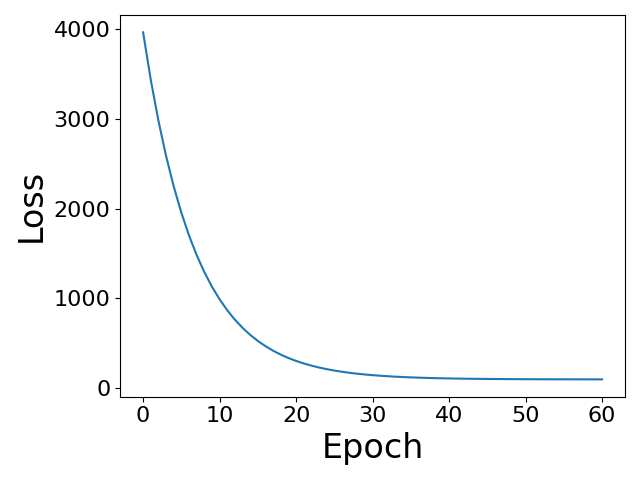

In [ ]:
plt.close()
plt.plot(loss_array)
plt.xlabel("Epoch", size=24)
plt.ylabel("Loss", size=24)
plt.tick_params(axis='both', labelsize=16)
plt.tight_layout()
plt.show()

### Investigating the progress of the loss function

Since in our case the loss function depends on only two parameters (w and b) it is possible to directly visualize its shape. Moreover, it is possible to visualize the trajectory that our optimization algorithm took in this loss function space. The below plot illustrates just that (note that this plot is interactive and you can rotate it):

<ipython-input-42-7c4383f51010>:3: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


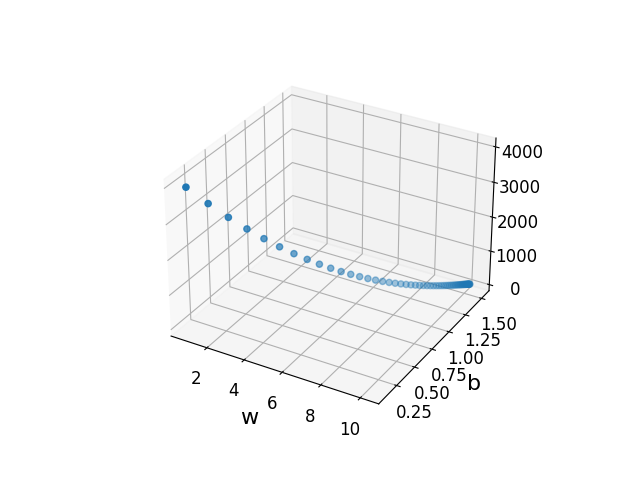

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.gca(projection='3d')

ax.scatter(w_array, b_array, loss_array)

ax.set_xlabel('w', size=16)
ax.set_ylabel('b', size=16)
ax.tick_params(labelsize=12)

plt.show()

Let's now extend our visualization by plotting it against the entire loss function in this region. Since the entire dataset is used for the computation of the loss function we obtain just one plane, and the trajectory that our optimizer takes is fairly smooth with almost no noise. This will not be the case when we start working with subsets of the data using stochastic gradient descent.

In [ ]:
loss_surface = []
w_surface = []
b_surface = []

for w_value in np.linspace(0, 20, 200):
    for b_value in np.linspace(-18, 22, 200):

        # Collect information about the loss function surface 
        w.assign(w_value)
        b.assign(b_value)

        Y_predicted = forward(X)
        loss_value = loss_fn(Y_predicted, Y)

        b_surface.append(b_value)
        w_surface.append(w_value)
        loss_surface.append(loss_value)

<ipython-input-44-aaf4527341c1>:4: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax2 = fig.gca(projection='3d')


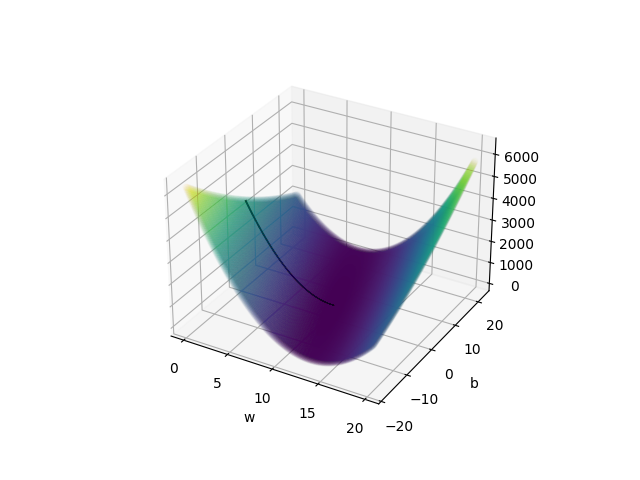

In [ ]:
plt.close()

fig = plt.figure()
ax2 = fig.gca(projection='3d')

ax2.scatter(w_surface, b_surface, loss_surface, c = loss_surface, alpha = 0.02)
ax2.plot(w_array, b_array, loss_array, color='black')

ax2.set_xlabel('w')
ax2.set_ylabel('b')

plt.show()

# Stochastic Gradient Descent

In contrast to gradient descent, stochastic gradient descent does not use the entire dataset for the calculation of the shape of the loss function. Instead smaller subsets of the data are used. This has profound implications for the behavior of our algorithm. Since every batch is different, even for the same set of weights, the calculated loss will be different for an individual batch than for the entire dataset. Since the loss function is different for the batch, the gradient of the loss function will be different as well, which introduces a level of noise.

Let's think about how stochastic gradient descent works as applied to our toy model. The thick green line illustrates the shape of the loss function given all the data. The thin green line is the shape of the loss function for an individual batch (sometimes called a minibatch). Since those curves are different the estimation of the gradient will be different at every step. This can be seen as adding an element of noise to the optimization process, hence the name "stochastic".

#### Step 1
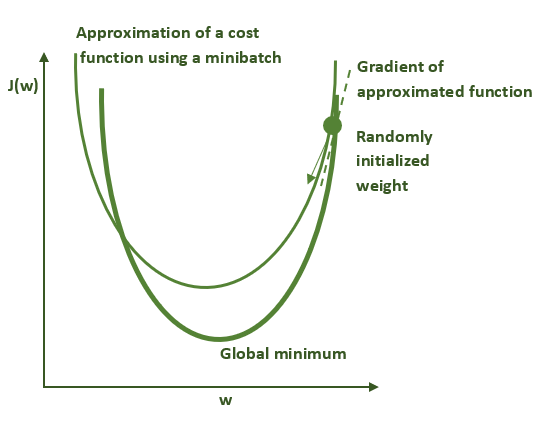

![](./images/SGD1.png)![SGD1.png](attachment:SGD1.png)

#### Step 2


> Indented block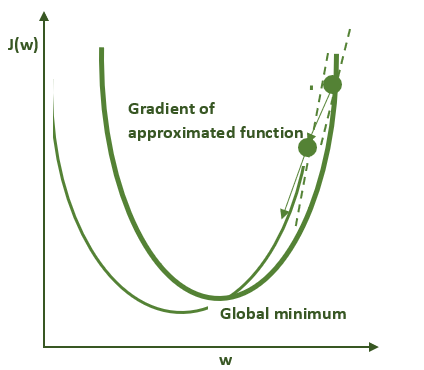



![](./images/SGD2.png)![SGD2.png](attachment:SGD2.png)

#### Step 3
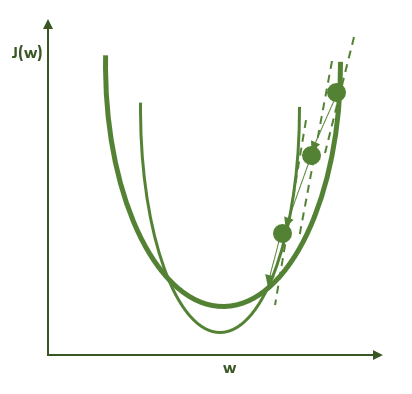
![](./images/SGD3.png)

This process can either be seen as generating an effective loss function which is mathematically different from the loss function for the full dataset (has different extrema), or it can be seen as helping to better locate the global minimum of the loss function of the full dataset because it is less likely to be trapped in local minima. (We will be investigating later how this plays out in the context of a realistic neural network model.) One can view gradient descent as an algorithm that averages out all of the noise of the batches, and larger batches as containing less noise than smaller batches.

## Implementing stochastic gradient descent: a first approach

To demonstrate this phenomenon let's make a small change to our code. Rather than providing all of the data to the model in every iteration, we will provide just a single example (batch size of 1), amplifying the effect.

In [ ]:
# Define the maximum number of times we want to process the entire dataset (the number of epochs).
# In practice we won't run this many because we'll implement an early stopping condition that
# detects when the training process has converged.
max_number_of_epochs = 1000

# We will store information about the optimization process here.
loss_array = []
b_array = []
w_array = []

# Zero out the initial values
w.assign(0.0)
b.assign(0.0)

# Print out the parameters and loss before we do any training
Y_predicted = forward(X)
loss_value = loss_fn(Y_predicted, Y)
print("Before training: w = {:4.3f}, b = {:4.3f}, loss = {:7.3f}".format(w.numpy(), b.numpy(), loss_value))

print("")
print("Starting training")
print("")

# Start the training process
for i in range(max_number_of_epochs):

    # Update after every data point
    for (x_pt, y_pt) in zip(x, y):

        with tf.GradientTape() as tape:
            y_predicted = forward(x_pt)
            loss_value = loss_fn([y_predicted], [y_pt])

        optimizer.minimize(loss_value, var_list=[w, b], tape=tape)

        # Capture the data that we will use in our visualization
        # Note that we are now updating our loss function after
        # every point in the sample, so the size of loss_array
        # will be greater by a factor of n_samples compared to
        # the last exercise.
        w_array.append(w.numpy())
        b_array.append(b.numpy())
        loss_array.append(loss_value)

    # At the end of every epoch after the first, print out the learned weights
    if i > 0:
        avg_w = sum(w_array[(i-1)*n_samples:(i  )*n_samples]) / n_samples
        avg_b = sum(b_array[(i-1)*n_samples:(i  )*n_samples]) / n_samples
        avg_loss = sum(loss_array[(i-1)*n_samples:(i  )*n_samples]) / n_samples
        print("Epoch = {:2d}: w = {:4.3f}, b = {:4.3f}, loss = {:7.3f}".format(i+1, avg_w, avg_b, avg_loss))

    # End the training when the loss function has not changed from the last epoch
    # by more than a small amount. Note that in our convergence check we will compare
    # the loss averaged over this epoch with the loss averaged over the last epoch.
    if i > 1:
        average_loss_this_epoch = sum(loss_array[(i-1)*n_samples:(i  )*n_samples]) / n_samples
        average_loss_last_epoch = sum(loss_array[(i-2)*n_samples:(i-1)*n_samples]) / n_samples
        if abs(average_loss_this_epoch - average_loss_last_epoch) / average_loss_last_epoch < 0.001:
            break

print("")
print("Training finished after {} epochs".format(i+1))
print("")
    
avg_w = sum(w_array[(i-1)*n_samples:(i  )*n_samples]) / n_samples
avg_b = sum(b_array[(i-1)*n_samples:(i  )*n_samples]) / n_samples
avg_loss = sum(loss_array[(i-1)*n_samples:(i  )*n_samples]) / n_samples
    
print("After training: w = {:4.3f}, b = {:4.3f}, loss = {:7.3f}".format(avg_w, avg_b, avg_loss))

Before training: w = 0.000, b = 0.000, loss = 3963.458

Starting training

Epoch =  2: w = 9.350, b = 1.267, loss = 391.068
Epoch =  3: w = 10.398, b = 1.358, loss = 104.405
Epoch =  4: w = 10.407, b = 1.304, loss = 104.378

Training finished after 4 epochs

After training: w = 10.407, b = 1.304, loss = 104.378


Compare the final loss value to what we obtained before, as well as the model parameters. You probably did not get the same value for the total loss -- was the answer any more accurate?

Let's plot the loss over time. One choice we can make is to plot the loss after every update. This will probably be a significantly noisier curve, since we aren't averaging out updates over an entire pass through the dataset.

In [ ]:
plt.close()
plt.plot(loss_array)
plt.xlabel("Number of Updates", size=24)
plt.ylabel("Loss", size=24)
plt.tick_params(axis='both', labelsize=16)
plt.tight_layout()
plt.show()

We can see a similar effect by plotting the trajectory taken by our optimizer in the loss space.

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

plt.close()

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(w_array, b_array, loss_array)

ax.set_xlabel('w', size=16)
ax.set_ylabel('b', size=16)
ax.tick_params(labelsize=12)

plt.show()

<div>Plotting the loss surface for one of the mini batches clearly illustrates that it no longer aligns with the optimization trajectory which was generated one minibatch at a time (and for every minibatch the loss surface was indeed different).</div>

In [ ]:
plt.close()

fig = plt.figure()
ax2 = fig.gca(projection='3d')

ax2.scatter(w_surface, b_surface, loss_surface, c = loss_surface, alpha = 0.02)
ax2.plot(w_array, b_array, loss_array, color='black')

ax2.set_xlabel('w')
ax2.set_ylabel('b')

plt.show()

## Experimenting with batch size in this toy model

So, we've now compared two extremes: stochastic gradient descent where the batch size is the full dataset (that is, traditional gradient descent), and SGD where the batch size is 1. Let's try out some batch sizes in the middle. To do this, modify the code we used above to pass a subset of the data to be trained on in each step. All you need to do is loop through the dataset in order, passing each consecutive chunk of batch size M to the optimizer. Your implementation ideally should work for any number M where 1 <= M <= N, where N is the number of items in the dataset. The dataset will usually not be evenly divisible by the size of the batch, so make sure you handle the last batch in the dataset by just using all the remaining items (so it will be a smaller batch).

In [ ]:
# Define the maximum number of times we want to process the entire dataset (the number of epochs).
# In practice we won't run this many because we'll implement an early stopping condition that
# detects when the training process has converged.
max_number_of_epochs = 1000

# We still store information about the optimization process here.
loss_array = []
b_array = []
w_array = []

# Zero out the initial values
w.assign(0.0)
b.assign(0.0)

# Print out the parameters and loss before we do any training
Y_predicted = forward(X)
loss_value = loss_fn(Y_predicted, Y)
print("Before training: w = {:4.3f}, b = {:4.3f}, loss = {:7.3f}".format(w.numpy(), b.numpy(), loss_value))

print("")
print("Starting training")
print("")

# Pass in batches of the dataset
# After the first run, try batch sizes of 16, 64, and 128
batch_size = 32
num_batches_in_epoch = FIXME

# Start the training process
for i in range(max_number_of_epochs):

    for j in range(num_batches_in_epoch):
        batch_start = FIXME
        batch_end = FIXME

        with tf.GradientTape() as tape:
            y_predicted = forward(x[batch_start:batch_end])
            loss_value = loss_fn(y_predicted, y[batch_start:batch_end])

        optimizer.minimize(loss_value, var_list=[w, b], tape=tape)

        # Capture the data that we will use in our visualization
        w_array.append(w.numpy())
        b_array.append(b.numpy())
        loss_array.append(loss_value)

    # At the end of every epoch after the first, print out the learned weights
    if i > 0:
        avg_w = sum(w_array[(i-1)*num_batches_in_epoch:(i  )*num_batches_in_epoch]) / num_batches_in_epoch
        avg_b = sum(b_array[(i-1)*num_batches_in_epoch:(i  )*num_batches_in_epoch]) / num_batches_in_epoch
        avg_loss = sum(loss_array[(i-1)*num_batches_in_epoch:(i  )*num_batches_in_epoch]) / num_batches_in_epoch
        print("Epoch = {:2d}: w = {:4.3f}, b = {:4.3f}, loss = {:7.3f}".format(i+1, avg_w, avg_b, avg_loss))

    # End the training when the loss function has not changed from the last epoch
    # by more than a small amount. Note that in our convergence check we will compare
    # the loss averaged over this epoch with the loss averaged over the last epoch.
    if i > 1:
        average_loss_this_epoch = sum(loss_array[(i-1)*num_batches_in_epoch:(i  )*num_batches_in_epoch]) / num_batches_in_epoch
        average_loss_last_epoch = sum(loss_array[(i-2)*num_batches_in_epoch:(i-1)*num_batches_in_epoch]) / num_batches_in_epoch
        if abs(average_loss_this_epoch - average_loss_last_epoch) / average_loss_last_epoch < 0.001:
            break

print("")
print("Training finished after {} epochs".format(i+1))
print("")

avg_w = sum(w_array[(i-1)*num_batches_in_epoch:(i  )*num_batches_in_epoch]) / num_batches_in_epoch
avg_b = sum(b_array[(i-1)*num_batches_in_epoch:(i  )*num_batches_in_epoch]) / num_batches_in_epoch
avg_loss = sum(loss_array[(i-1)*num_batches_in_epoch:(i  )*num_batches_in_epoch]) / num_batches_in_epoch

print("After training: w = {:4.3f}, b = {:4.3f}, loss = {:7.3f}".format(avg_w, avg_b, avg_loss))

If you get stuck with the above exercise, reveal the cell below to see an example solution.

<font face="courier">
<pre>

num_batches_in_epoch = (n_samples + batch_size - 1) // batch_size
    
...

    for j in range(num_batches_in_epoch):
        batch_start = j * batch_size
        batch_end = min((j + 1) * batch_size, n_samples)

</pre>
</font>

Now for each batch size you try, repeat the plotting process to see how things went. Note which batch size yielded the best final accuracy, but in particular pay attention to the smoothness of the accuracy curve as a function of epoch count, and consider how that smoothness depends on batch size.

In [ ]:
plt.close()
plt.plot(loss_array)
plt.xlabel("Number of Updates", size=24)
plt.ylabel("Loss", size=24)
plt.tick_params(axis='both', labelsize=16)
plt.tight_layout()
plt.show()

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

plt.close()

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(w_array, b_array, loss_array)

ax.set_xlabel('w', size=16)
ax.set_ylabel('b', size=16)
ax.tick_params(labelsize=12)

plt.show()

In [ ]:
plt.close()

fig = plt.figure()
ax2 = fig.gca(projection='3d')

ax2.scatter(w_surface, b_surface, loss_surface, c = loss_surface, alpha = 0.02)
ax2.plot(w_array, b_array, loss_array, color='black')

ax2.set_xlabel('w')
ax2.set_ylabel('b')

plt.show()

## Conclusion

In this task we have learned:

- The basic components of the neural network training process
- How to implement a gradient descent optimizer
- The difference between gradient descent and stochastic gradient descent and the impact they have on the optimization process
- How batch size affects training accuracy